Importing the necessary libraries:


In [23]:
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tabulate import tabulate
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\costi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\costi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\costi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Setting up the directories

In [4]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_dir = os.path.join(base_dir, "src")
data_dir = os.path.join(base_dir, "data")
rda_2017_dir = os.path.join(data_dir, "rumor-detection-acl-2017")
twitter15_dir = os.path.join(rda_2017_dir, "twitter15")
twitter16_dir = os.path.join(rda_2017_dir, "twitter16")

creating the dataframe

In [9]:
labels = []
tweet_ids = []
with open(f'{twitter16_dir}/label.txt', 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        label, tweet_id = line.split(':', 1)
        tweet_ids.append(tweet_id)
        labels.append(label)

df_labels = pd.DataFrame({
    'tweet_id': tweet_ids,
    'label': labels
})

tweet_text_ids = []
tweet_texts = []
with open(f'{twitter16_dir}/source_tweets.txt', 'r', encoding='utf-8') as f:
    for line in f:
        if not line:
            continue
        tweet_id, text = line.split('\t', 1)
        tweet_text_ids.append(tweet_id)
        tweet_texts.append(text)

df_tweet = pd.DataFrame({
    'tweet_id': tweet_text_ids,
    'text': tweet_texts
})

df_merged = pd.merge(df_labels, df_tweet, on='tweet_id', how='inner')

print(tabulate(df_merged.head(), headers='keys', tablefmt='psql'))

+----+--------------------+------------+--------------------------------------------------------------------------------------------------+
|    |           tweet_id | label      | text                                                                                             |
|----+--------------------+------------+--------------------------------------------------------------------------------------------------|
|  0 | 656955120626880512 | false      | correct predictions in back to the future ii URL                                                 |
|  1 | 615689290706595840 | true       | .@whitehouse in rainbow colors for #scotusmarriage? here's what i think about that decision: URL |
|  2 | 613404935003217920 | false      | cops bought the alleged church shooter burger king hours after killings URL                      |
|  3 | 731166399389962242 | unverified | 🔥ca kkk grand wizard 🔥 endorses @hillaryclinton #neverhillary #trump2016 URL                   |
|  4 | 714598641827246

Label counts:

In [10]:
label_counts = df_merged['label'].value_counts()
print(tabulate(label_counts.reset_index(), headers=['Label', 'Count'], tablefmt='psql'))

+----+------------+---------+
|    | Label      |   Count |
|----+------------+---------|
|  0 | true       |     207 |
|  1 | false      |     205 |
|  2 | non-rumor  |     205 |
|  3 | unverified |     201 |
+----+------------+---------+


Text count distribution:

In [12]:
df_merged['text_length'] = df_merged['text'].apply(lambda x: len(x.split()))
df_merged['char_length'] = df_merged['text'].apply(len)

print(tabulate(df_merged[['text_length','char_length']].describe(), headers='keys', tablefmt='psql'))

+-------+---------------+---------------+
|       |   text_length |   char_length |
|-------+---------------+---------------|
| count |     818       |      818      |
| mean  |      15.187   |       92.066  |
| std   |       4.17171 |       23.5541 |
| min   |       3       |       22      |
| 25%   |      12       |       77      |
| 50%   |      15       |       94      |
| 75%   |      18       |      111      |
| max   |      28       |      141      |
+-------+---------------+---------------+


Cleaning the text:

In [13]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [20]:
def clean_text(text):
    text = text.lower()

    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'@', '', text)
    text = re.sub(r'[^a-z\s]', '', text)

    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)

In [21]:
df_merged['clean_text'] = df_merged['text'].apply(clean_text)

In [22]:
print(tabulate(df_merged[['text','clean_text']].head(), headers='keys', tablefmt='psql'))

+----+--------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------+
|    | text                                                                                             | clean_text                                                                |
|----+--------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------|
|  0 | correct predictions in back to the future ii URL                                                 | correct prediction back future url                                        |
|  1 | .@whitehouse in rainbow colors for #scotusmarriage? here's what i think about that decision: URL | whitehouse rainbow color scotusmarriage here think decision url           |
|  2 | cops bought the alleged church shooter burger king hours after killings URL        

All tweets word cloud:

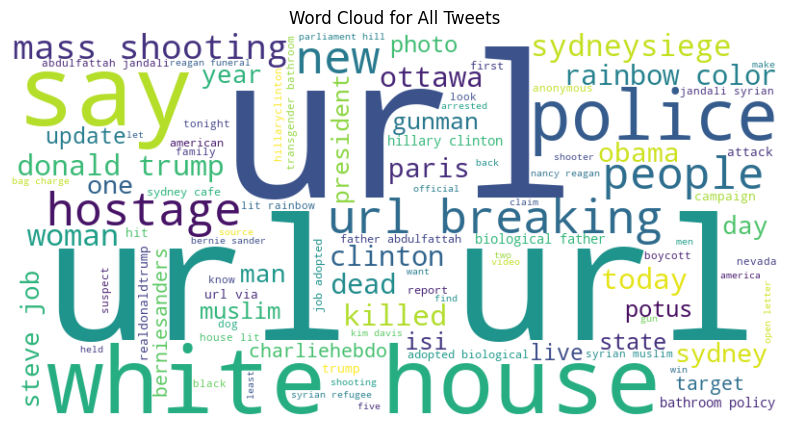

In [24]:
all_text = ' '.join(df_merged['clean_text'].values)

wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    max_words=100
).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Tweets')
plt.show()

Word cloud for each label:


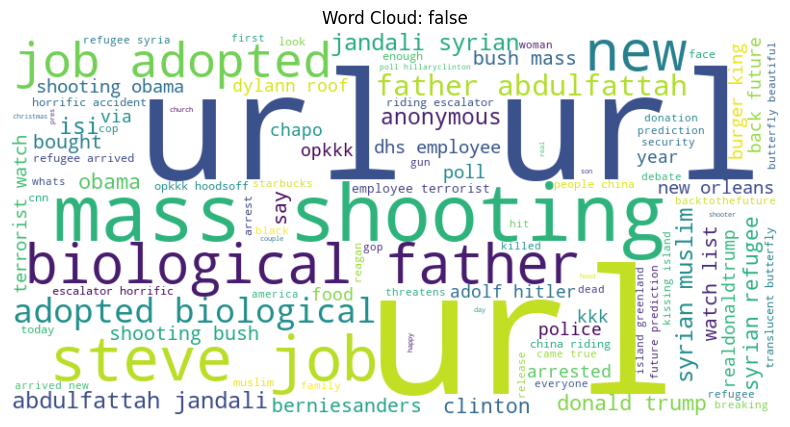

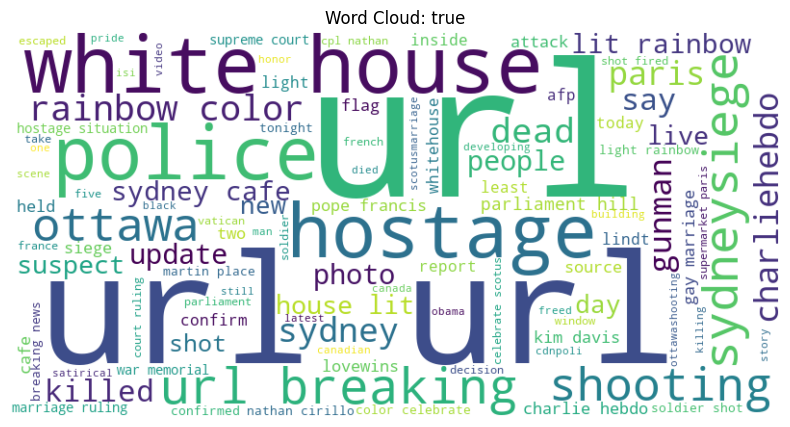

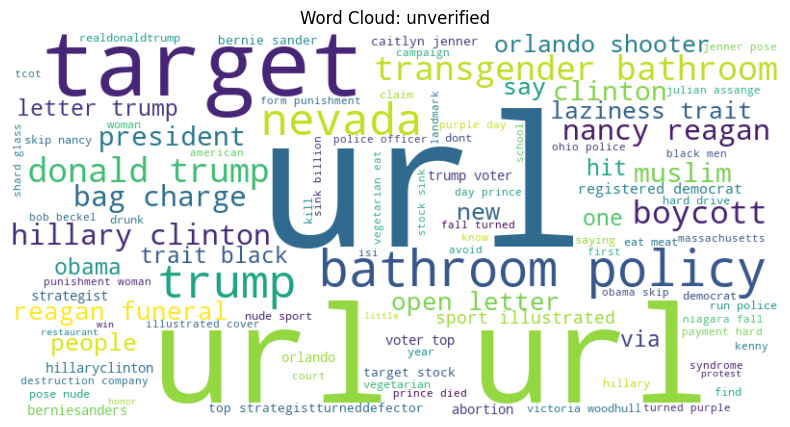

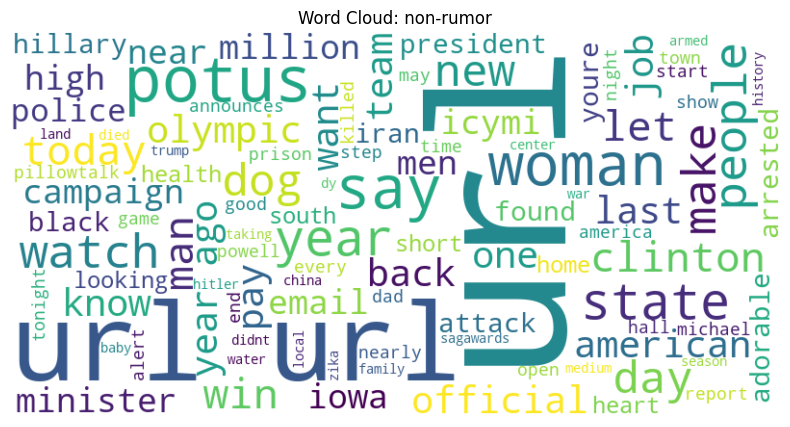

In [25]:
for label_name in df_merged['label'].unique():
    subset = df_merged[df_merged['label'] == label_name]
    label_text = ' '.join(subset['clean_text'].values)

    wc_label = WordCloud(
        width=800, height=400,
        background_color='white',
        max_words=100
    ).generate(label_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc_label, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud: {label_name}')
    plt.show()